## Missed Trash Pickups

In this data question you will work with service request data related to missed trash pickups from [hubNashville](https://hub.nashville.gov), Metro Nashville government's comprehensive customer service system.

Your goal is to practice working with dates, times, and time-based aggregation in pandas while exploring patterns in missed pickups. You’ll also calculate fines based on missed pickups within a rolling time window.

In [1]:
import pandas as pd


In [2]:
trash_report=pd.read_csv("../data/trash_hauler_report_with_lat_lng.csv")
trash_report.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE
0,25270,11/1/2017,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292
1,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470
2,25276,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923
3,25307,11/1/2017,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652
4,25312,11/1/2017,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861


In [3]:
trash_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Request Number    20226 non-null  int64  
 1   Date Opened       20226 non-null  object 
 2   Request           20226 non-null  object 
 3   Description       20195 non-null  object 
 4   Incident Address  20217 non-null  object 
 5   Zip Code          20151 non-null  float64
 6   Trash Hauler      19325 non-null  object 
 7   Trash Route       19279 non-null  object 
 8   Council District  20177 non-null  float64
 9   State Plan X      20198 non-null  float64
 10  State Plan Y      20198 non-null  float64
 11  LONGITUDE         20198 non-null  float64
 12  LATITUDE          20198 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.0+ MB


**Step 1: Data Preparation**

1. Convert any date columns to datetime using pd.to_datetime().  

In [4]:
trash_report['Date Opened'] = pd.to_datetime(trash_report['Date Opened'])
trash_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    20226 non-null  int64         
 1   Date Opened       20226 non-null  datetime64[ns]
 2   Request           20226 non-null  object        
 3   Description       20195 non-null  object        
 4   Incident Address  20217 non-null  object        
 5   Zip Code          20151 non-null  float64       
 6   Trash Hauler      19325 non-null  object        
 7   Trash Route       19279 non-null  object        
 8   Council District  20177 non-null  float64       
 9   State Plan X      20198 non-null  float64       
 10  State Plan Y      20198 non-null  float64       
 11  LONGITUDE         20198 non-null  float64       
 12  LATITUDE          20198 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 2.0+ MB


2. Create new columns for:  
    * year, month, day
    * day_of_week (or weekday name)

In [5]:
trash_report['year_opened']=trash_report['Date Opened'].dt.year

In [6]:
trash_report['month_opened']=trash_report['Date Opened'].dt.month

In [7]:
trash_report['day_opened']=trash_report['Date Opened'].dt.day
trash_report['day_opened'].head()

0    1
1    1
2    1
3    1
4    1
Name: day_opened, dtype: int32

In [8]:
trash_report['day_of_week']= trash_report['Date Opened'].dt.day_name()
trash_report['day_of_week'].head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: day_of_week, dtype: object

In [9]:
trash_report.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,year_opened,month_opened,day_opened,day_of_week
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,2017,11,1,Wednesday
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,2017,11,1,Wednesday
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,2017,11,1,Wednesday


3. Filter the data so that you are only analyzing actual missed pickups.

In [10]:
filter_trash_report= trash_report[trash_report['Request'].str.contains("Trash - Curbside/Alley Missed Pickup")]
filter_trash_report

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,year_opened,month_opened,day_opened,day_of_week
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,2017,11,1,Wednesday
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,2017,11,1,Wednesday
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,2017,11,1,Wednesday
8,25330,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed.,4484 Lavergne Couchville Pike,37013.0,RED RIVER,4210,33.0,1794533.514,618749.3427,-86.588364,36.031728,2017,11,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221,267125,2019-11-01,Trash - Curbside/Alley Missed Pickup,MISSED...NEIGHBORS MISSED,2731 Murfreesboro Pike,37013.0,RED RIVER,4502,32.0,1781137.263,632448.5511,-86.633970,36.069130,2019,11,1,Friday
20222,267126,2019-11-01,Trash - Curbside/Alley Missed Pickup,entire alley,"1621 Long Ave, Nashville, TN 37206, United States",37206.0,METRO,9508,6.0,1749711.399,669201.6016,-86.741242,36.169482,2019,11,1,Friday
20223,267130,2019-11-01,Trash - Curbside/Alley Missed Pickup,missed several,"2943 Windemere Cir, Nashville, TN 37214, Unite...",37214.0,RED RIVER,1502,15.0,1770293.388,674936.3038,-86.671647,36.185643,2019,11,1,Friday
20224,267134,2019-11-01,Trash - Curbside/Alley Missed Pickup,Caller stated trash was missed & were only pic...,"3325 Murfreesboro Pike, Nashville, TN 37013, U...",37013.0,RED RIVER,4502,32.0,1785224.998,627146.4002,-86.620025,36.054637,2019,11,1,Friday


**Step 2: Explore Time-Based Patterns**  
Answer these simpler questions first:  

1. Which day of the week has the highest number of missed pickups?

In [11]:
filter_trash_report['day_of_week'].dropna().max()

'Wednesday'

2. Missed pickups over time:  

* Find the total number of missed pickups by month. Plot this with a line chart.  
   

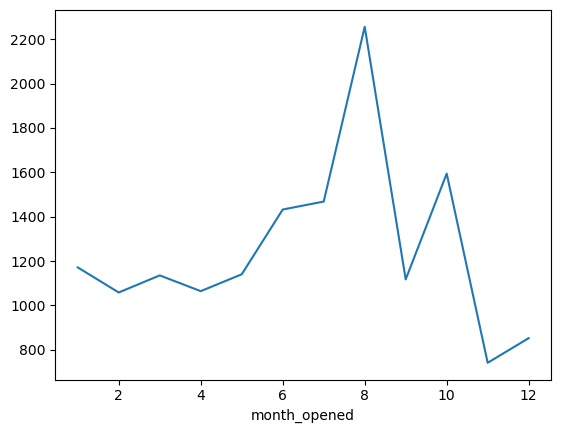

In [12]:
filter_trash_report.groupby('month_opened').size().plot();

 * Create a plot showing the number of missed pickups per day.  
    

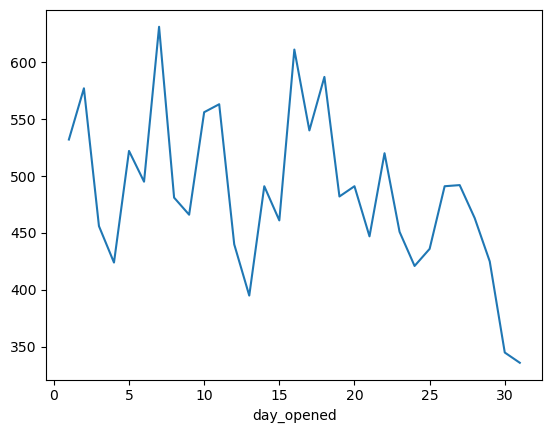

In [13]:
filter_trash_report.groupby('day_opened').size().plot();

In [14]:
missed_per_day = filter_trash_report.groupby('Date Opened').size().reset_index()
missed_per_day.columns = ['Date Opened', 'num_missed_pickups']
missed_per_day
missed_per_day['Date Opened'] = pd.to_datetime(missed_per_day['Date Opened'])
missed_per_day.head()

,Date Opened,num_missed_pickups
0,2017-11-01,25
1,2017-11-02,29
2,2017-11-03,19
3,2017-11-05,2
4,2017-11-06,21


* Compute a rolling 30-day average of daily missed pickups. Visualize your results with a line chart to see trends.

In [15]:
missed_per_day.rolling(window = '30D', on='Date Opened')['num_missed_pickups'].mean()

0      25.000000
1      27.000000
2      24.333333
3      18.750000
4      19.200000
         ...    
675    35.266667
676    35.700000
677    35.733333
678    35.833333
679    35.933333
Name: num_missed_pickups, Length: 680, dtype: float64

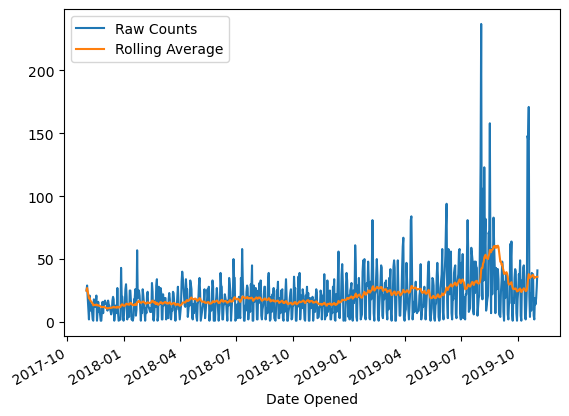

In [16]:
missed_per_day['rolling_30D'] = missed_per_day.rolling(window = '30D', on='Date Opened')['num_missed_pickups'].mean()
ax = missed_per_day.plot(x='Date Opened', y='num_missed_pickups', label= 'Raw Counts')
missed_per_day.plot(x='Date Opened', y='rolling_30D', label= 'Rolling Average', ax=ax);

**Step 3: Main Task – 180-Day Rolling Fine Calculation**  
Metro Nashville charges fines for excessive missed trash pickups. It uses the following method to calculate the total fine:  A $1500 fine is charged for each missed pickup that is the third or subsequent one at the same address within a 180-day window. Multiple fines may apply to the same address.  
What is the total fine across all addresses? **Hint:** The rolling method can be use in combination with groupby.

In [17]:
metro_report = filter_trash_report.dropna(subset=["Incident Address"]).copy()
metro_report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15020 entries, 1 to 20225
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    15020 non-null  int64         
 1   Date Opened       15020 non-null  datetime64[ns]
 2   Request           15020 non-null  object        
 3   Description       14991 non-null  object        
 4   Incident Address  15020 non-null  object        
 5   Zip Code          14970 non-null  float64       
 6   Trash Hauler      14420 non-null  object        
 7   Trash Route       14403 non-null  object        
 8   Council District  14989 non-null  float64       
 9   State Plan X      15005 non-null  float64       
 10  State Plan Y      15005 non-null  float64       
 11  LONGITUDE         15005 non-null  float64       
 12  LATITUDE          15005 non-null  float64       
 13  year_opened       15020 non-null  int32         
 14  month_opened      15020 non

In [21]:
metro_report_clean = metro_report.sort_values(["Incident Address", "Date Opened"])
metro_report_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15020 entries, 4477 to 891
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    15020 non-null  int64         
 1   Date Opened       15020 non-null  datetime64[ns]
 2   Request           15020 non-null  object        
 3   Description       14991 non-null  object        
 4   Incident Address  15020 non-null  object        
 5   Zip Code          14970 non-null  float64       
 6   Trash Hauler      14420 non-null  object        
 7   Trash Route       14403 non-null  object        
 8   Council District  14989 non-null  float64       
 9   State Plan X      15005 non-null  float64       
 10  State Plan Y      15005 non-null  float64       
 11  LONGITUDE         15005 non-null  float64       
 12  LATITUDE          15005 non-null  float64       
 13  year_opened       15020 non-null  int32         
 14  month_opened      15020 no

In [51]:
metro_fines = (
    metro_report_clean                      
    .groupby("Incident Address")
    .rolling("180D", on = "Date Opened")
    .count()
    .reset_index()
)
filtered_metro_fines=metro_fines[["Incident Address","Date Opened", "Request"]]
filtered_metro_fines=filtered_metro_fines.rename(columns = {"Request":"count_180d"})
filtered_metro_fines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15020 entries, 0 to 15019
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Incident Address  15020 non-null  object        
 1   Date Opened       15020 non-null  datetime64[ns]
 2   count_180d        15020 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 352.2+ KB


In [52]:
filtered_metro_fines["count_180d"].astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
15015    2
15016    3
15017    1
15018    1
15019    1
Name: count_180d, Length: 15020, dtype: int64

In [53]:
filtered_metro_fines["fine"]=(filtered_metro_fines["count_180d"]>=3) * 1500
filtered_metro_fines["fine"].sum()

np.int64(1591500)